<a href="https://colab.research.google.com/github/ErickMM98/kaggle-housesprice-colab/blob/main/Kaggle_HousePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition - House Prices - Advanced Regression Techniques

- Tenemos > 70 variables explicativas. 
- **Objetivo:** Dar el precio de la casa en cuestión.

[Link a Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)



## Importamos los datos desde Kaggle por la API

In [2]:
!mkdir ~/.kaggle
#GUARDAR .json EN ALGUNA CARPETA DE DRIVE
!cp /content/drive/MyDrive/TestFolder/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


## Análisis estadístico y algunas modificaciones de los datos.

In [4]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import itertools
import scipy.stats as stats

plt.style.use('ggplot')
mpl.rcParams['text.usetex'] = 0
mpl.rcParams['xtick.labelsize'] = 10 


"""
----- GLOBAL VARIABLES
"""

str_path_test = "/content/test.csv"
str_path_train = "/content/train.csv"

In [5]:
df_test = pd.read_csv(str_path_test)
df_data = pd.read_csv(str_path_train)

columns = df_data.columns
array_bool_object = (df_data.dtypes == object)
array_bool_float = (df_data.dtypes == float)
array_bool_int = (df_data.dtypes == int)

print(np.sum(array_bool_float), 
      np.sum(array_bool_object),
      np.sum(array_bool_int))

#df_data[columns[array_bool_int]]

df_data.shape

3 43 35


(1460, 81)

### Datos faltantes y eliminación de variables.

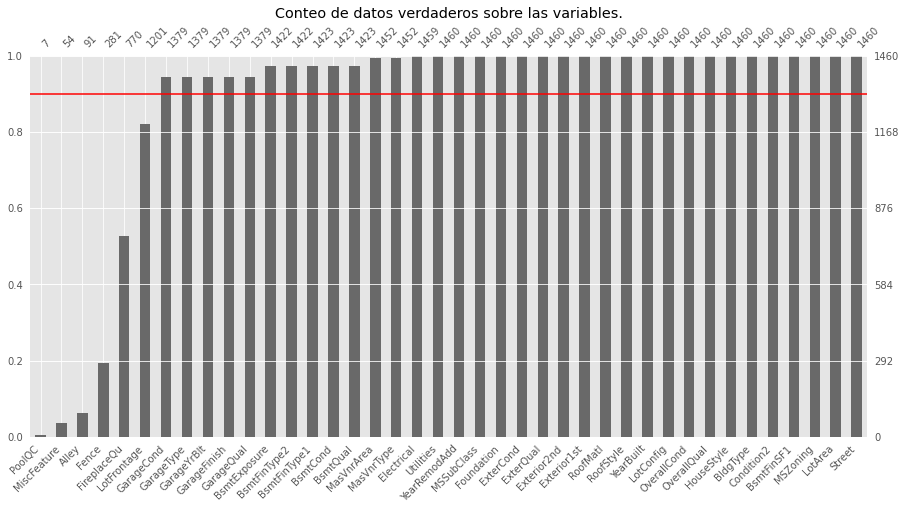

In [ ]:
null_var = list(df_data.isna().sum().sort_values(ascending=False).index)[0:40]
#plt.plot(df_test.isna().sum().sort_values(ascending=False))
#df_test.isna().sum().sort_values(ascending=False).head(40)
df_faltantes = df_data[null_var]
#df_train['SalePrice']
fig, ax = plt.subplots()
fig.set_size_inches([15,7])
msno.bar(df_faltantes , ax = ax,fontsize=10)
xleft, xright = ax.set_xlim()
ax.hlines(y=0.90, xmin=xleft,
          xmax = xright, color = 'r')
ax.set_title('Conteo de datos verdaderos sobre las variables.')
fig.savefig("datosfaltantes_train.pdf")

Aparentemente, tenemos muchos datos faltantes en *PoolQC, MscFeature, Alley, Fence, FireplaceQu*. Con base en *data_description.txt*, estos hacen referencia a que **NO** son errores, sino que tienen asociado una ausencia justificada. 

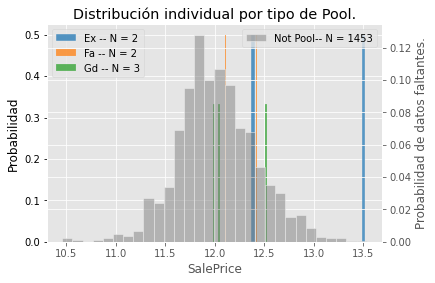

In [ ]:
#@title Sobre PoolQC
fig, ax = plt.subplots()
ax2 = ax.twinx()
#fig.set_size_inches([15,7])
#list_ax = list(ax[0]) + list(ax[1])
df_foo = df_data.copy()
df_foo['SalePrice'] = np.log(df_foo['SalePrice'])
df_foo['PoolQC'] = df_foo['PoolQC'].fillna('NAN')
color_set = ['gray'] + [plt.cm.tab10(i) for i in range(10)]
dict_count = df_foo['PoolQC'].value_counts().to_dict()
for i,tipopool in enumerate(df_foo['PoolQC'].unique()):
  #axe = list_ax[i]
  if i > 0:
    df_aux = df_foo[df_foo['PoolQC'] == tipopool]
    histplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax, stat='probability',
                color = color_set[i])
    histplot.legend(['Ex -- N = {}'.format(dict_count['Ex']),
                     'Fa -- N = {}'.format(dict_count['Fa']),
                     'Gd -- N = {}'.format(dict_count['Gd'])],
                    loc = 'upper left')
  else:
    df_aux = df_foo[df_foo['PoolQC'] == tipopool]
    grayhistplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax2, stat='probability',
                color = color_set[i],alpha = 0.5 )
    grayhistplot.legend(['Not Pool-- N = {}'.format(dict_count['NAN'])],loc = 'upper right')

ax.set_title("Distribución individual por tipo de Pool.")
ax.set_ylabel("Probabilidad", color = 'Black')
ax.tick_params(axis='y', colors='Black')
ax2.set_ylabel("Probabilidad de datos faltantes.")

fig.savefig("poolqc.pdf")

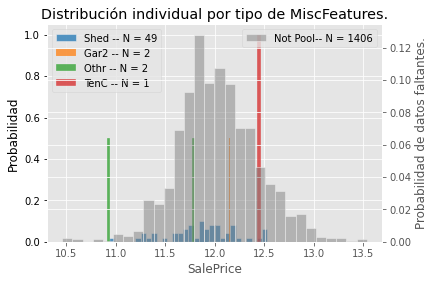

In [ ]:
#@title Sobre MscFeature
fig, ax = plt.subplots()
ax2 = ax.twinx()
#fig.set_size_inches([15,7])
#list_ax = list(ax[0]) + list(ax[1])
df_foo = df_data.copy()
df_foo['SalePrice'] = np.log(df_foo['SalePrice'])
df_foo['MiscFeature'] = df_foo['MiscFeature'].fillna('NAN')
color_set = ['gray'] + [plt.cm.tab10(i) for i in range(10)]
dict_count = df_foo['MiscFeature'].value_counts().to_dict()
for i,tipopool in enumerate(df_foo['MiscFeature'].unique()):
  if i > 0:
    df_aux = df_foo[df_foo['MiscFeature'] == tipopool]
    histplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax, stat='probability',
                color = color_set[i])
    histplot.legend(['Shed -- N = {}'.format(dict_count['Shed']),
                     'Gar2 -- N = {}'.format(dict_count['Gar2']),
                     'Othr -- N = {}'.format(dict_count['Othr']),
                     'TenC -- N = {}'.format(dict_count['TenC'])],
                    loc = 'upper left')
  else:
    df_aux = df_foo[df_foo['MiscFeature'] == tipopool]
    grayhistplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax2, stat='probability',
                color = color_set[i],alpha = 0.5 )
    grayhistplot.legend(['Not Pool-- N = {}'.format(dict_count['NAN'])],loc = 'upper right')

ax.set_title("Distribución individual por tipo de MiscFeatures.")
ax.set_ylabel("Probabilidad", color = 'Black')
ax.tick_params(axis='y', colors='Black')
ax2.set_ylabel("Probabilidad de datos faltantes.")

fig.savefig("miscfeatures.pdf")

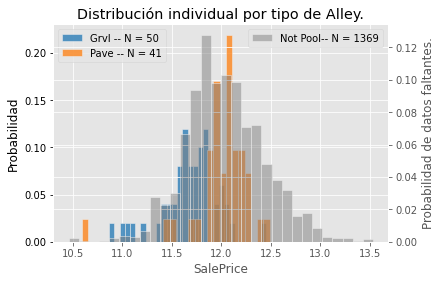

In [ ]:
#@title Sobre Alley
column_int = 'Alley'
fig, ax = plt.subplots()
ax2 = ax.twinx()
#fig.set_size_inches([15,7])
#list_ax = list(ax[0]) + list(ax[1])
df_foo = df_data.copy()
df_foo['SalePrice'] = np.log(df_foo['SalePrice'])
df_foo[column_int] = df_foo[column_int].fillna('NAN')
color_set = ['gray'] + [plt.cm.tab10(i) for i in range(10)]
dict_count = df_foo[column_int].value_counts().to_dict()
for i,tipopool in enumerate(df_foo[column_int].unique()):
  if i > 0:
    df_aux = df_foo[df_foo[column_int] == tipopool]
    histplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax, stat='probability',
                color = color_set[i])
  else:
    df_aux = df_foo[df_foo[column_int] == tipopool]
    grayhistplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax2, stat='probability',
                color = color_set[i] , alpha = 0.5)
    grayhistplot.legend(['Not Pool-- N = {}'.format(dict_count['NAN'])],loc = 'upper right')

histplot.legend(['{} -- N = {}'.format(tipopool ,dict_count[tipopool]) for i,tipopool in enumerate(df_foo[column_int].unique()) if i > 0 ],
                loc = 'upper left')

ax.set_title("Distribución individual por tipo de {}.".format(column_int))
ax.set_ylabel("Probabilidad", color = 'Black')
ax.tick_params(axis='y', colors='Black')
ax2.set_ylabel("Probabilidad de datos faltantes.")

fig.savefig("alley.pdf")

In [ ]:
df = df_foo.copy()['Alley']
fvalue, pvalue = stats.f_oneway(df_foo[df =='Grvl']['SalePrice'], 
                                df_foo[ df =='Pave']['SalePrice'],
                                df_foo[ df =='NAN']['SalePrice'])
print(fvalue, pvalue)

20.705973992838512 1.3581081167013773e-09


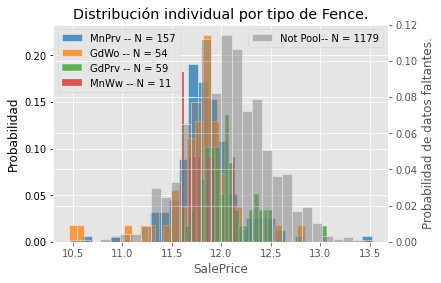

In [ ]:
#@title Sobre Fence
column_int = 'Fence'
fig, ax = plt.subplots()
ax2 = ax.twinx()
#fig.set_size_inches([15,7])
#list_ax = list(ax[0]) + list(ax[1])
df_foo = df_data.copy()
df_foo['SalePrice'] = np.log(df_foo['SalePrice'])
df_foo[column_int] = df_foo[column_int].fillna('NAN')
color_set = ['gray'] + [plt.cm.tab10(i) for i in range(10)]
dict_count = df_foo[column_int].value_counts().to_dict()
for i,tipopool in enumerate(df_foo[column_int].unique()):
  if i > 0:
    df_aux = df_foo[df_foo[column_int] == tipopool]
    histplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax, stat='probability',
                color = color_set[i])
  else:
    df_aux = df_foo[df_foo[column_int] == tipopool]
    grayhistplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax2, stat='probability',
                color = color_set[i], alpha = 0.5)
    grayhistplot.legend(['Not Pool-- N = {}'.format(dict_count['NAN'])],loc = 'upper right')

histplot.legend(['{} -- N = {}'.format(tipopool ,dict_count[tipopool]) for i,tipopool in enumerate(df_foo[column_int].unique()) if i > 0 ],
                loc = 'upper left')

ax.set_title("Distribución individual por tipo de {}.".format(column_int))
ax.set_ylabel("Probabilidad", color = 'Black')
ax.tick_params(axis='y', colors='Black')
ax2.set_ylabel("Probabilidad de datos faltantes.")
fig.savefig("fence.pdf")

In [ ]:
df = df_foo.copy()['Fence']
fvalue, pvalue = stats.kruskal(df_foo[df =='MnPrv']['SalePrice'], 
                                df_foo[ df =='GdWo']['SalePrice'],
                                df_foo[ df =='GdPrv']['SalePrice'],
                                df_foo[ df =='MnWw']['SalePrice'],
                                df_foo[df == 'NAN']['SalePrice'], 
                                df_foo[ df =='GdPrv']['SalePrice'])
print(fvalue, pvalue)

80.69340588066957 6.008543262242746e-16


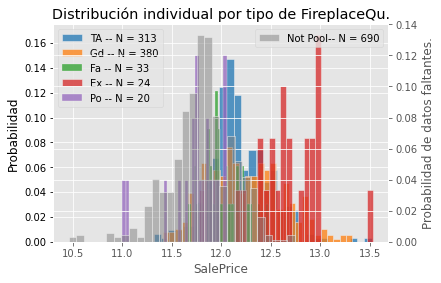

In [ ]:
#@title Sobre FireplaceQu
column_int = 'FireplaceQu'
fig, ax = plt.subplots()
ax2 = ax.twinx()
#fig.set_size_inches([15,7])
#list_ax = list(ax[0]) + list(ax[1])
df_foo = df_data.copy()
df_foo['SalePrice'] = np.log(df_foo['SalePrice'])
df_foo[column_int] = df_foo[column_int].fillna('NAN')
#color_set = ['gray','green','blue', 'red', 'purple']
color_set = ['gray'] + [plt.cm.tab10(i) for i in range(10)]
dict_count = df_foo[column_int].value_counts().to_dict()
for i,tipopool in enumerate(df_foo[column_int].unique()):
  if i > 0:
    df_aux = df_foo[df_foo[column_int] == tipopool]
    histplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax, stat='probability',
                color = color_set[i])
  else:
    df_aux = df_foo[df_foo[column_int] == tipopool]
    grayhistplot = sns.histplot(data=df_aux, x="SalePrice",bins=30, ax= ax2, stat='probability',
                color = color_set[i],alpha = 0.5)
    grayhistplot.legend(['Not Pool-- N = {}'.format(dict_count['NAN'])],loc = 'upper right')

histplot.legend(['{} -- N = {}'.format(tipopool ,dict_count[tipopool]) for i,tipopool in enumerate(df_foo[column_int].unique()) if i > 0 ],
                loc = 'upper left')

ax.set_title("Distribución individual por tipo de {}.".format(column_int))
ax.set_ylabel("Probabilidad", color = 'Black')
ax.tick_params(axis='y', colors='Black')
ax2.set_ylabel("Probabilidad de datos faltantes.")

fig.savefig("fireplacequ.pdf")

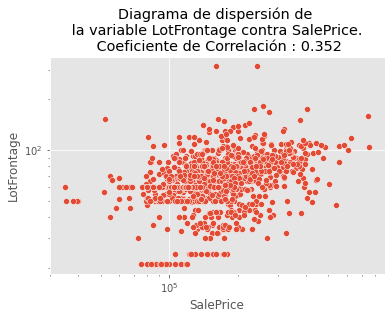

In [ ]:
#@title Sobre LotFrontage
column_int = 'LotFrontage'
fig, ax = plt.subplots()
#fig.set_size_inches([15,7])
#list_ax = list(ax[0]) + list(ax[1])
df_foo = df_data.copy()
df_foo = df_foo[~df_foo['LotFrontage'].isna()]
#df_foo['SalePrice'] = np.log(df_foo['SalePrice'])
#df_foo[column_int] = np.log(df_foo[column_int])
corr = df_foo[['SalePrice', column_int]].corr().iloc[0,1]
sns.scatterplot(data=df_foo, x='SalePrice', y = column_int, ax=ax)

ax.set_title("Diagrama de dispersión de \n la variable {} contra SalePrice. \n Coeficiente de Correlación : {:.3f}".format(column_int, corr))
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig("LofFrontage.pdf")

Por lo gráficos anteriores, descartamos las siguiente variables del *dataframe  train*. 
- ***PoolQC***
- ***MScFeature***
- ***Alley***
- ***Fence***
- ***FireplaceQu***
- ***LotFrontage***

### Sobre la imputación de los datos.

Para este caso, vamos a hacerlo dependediendo de la columna o variable. Esto es, si es categórica, colocamos el más frecuente. Si es contíuna, usamos KNN.

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
column_eliminate = ["PoolQC",
                    "MiscFeature",
                    "Alley",
                    "Fence",
                    "FireplaceQu",
                    "LotFrontage"]

df_columns_int = df_data.drop(column_eliminate, axis = 1)
#df_columns_int['SalePrice'] = np.log(df_columns_int['SalePrice'])

#Columnas con algunos datos faltantes
list_null_axes = df_columns_int.isna().sum()[df_columns_int.isna().sum() > 0 ].index
dict_type = df_columns_int.dtypes.to_dict()

columns_objets = [column for column in list_null_axes if str(dict_type[column]) != 'float64' or column == 'GarageYrBlt']
columns_float = [column for column in list_null_axes if str(dict_type[column]) == 'float64' and column != 'GarageYrBlt']

df_complete_data = df_columns_int.copy()

#Para las continuas
imputer = KNNImputer(n_neighbors=5)
df_complete_data[columns_float] = imputer.fit_transform(df_complete_data[columns_float])
#df_complete_data[columns_float] = imputer.fit_transform(df_complete_data[columns_float])

#Para las otras
imp = SimpleImputer(strategy="most_frequent")
df_complete_data[columns_objets] = imp.fit_transform(df_complete_data[columns_objets])


"""
df_columns_int['MasVnrArea'] = np.log(df_columns_int['MasVnrArea'])

#Columnas con algunos datos faltantes
list_null_axes = df_columns_int.isna().sum()[df_columns_int.isna().sum() > 0 ].index
dict_type = df_columns_int.dtypes.to_dict()

fig, ax = plt.subplots(4,3)
fig.set_size_inches([15,20])
list_ax = list(ax[0]) +  list(ax[1]) + list(ax[2]) + list(ax[3])

i = 0
for column in list_null_axes:
  print( column, '\t',dict_type[column], '\t', df_columns_int.isna().sum()[df_columns_int.isna().sum() > 0 ][column])
  if str(dict_type[column]) != 'float64' or column == 'GarageYrBlt':
    axe = list_ax[i]
    #axe.set_title(column)
    sns.violinplot(y = 'SalePrice', x = column, ax= axe, data=df_columns_int)
    if not i%3:
      axe.set_ylabel('$Log(SalePrice)$')
    else:
      axe.set_ylabel('')

    if column == 'GarageYrBlt':
      ticks = axe.get_xticklabels()
      print(ticks)

    i+=1

for column in list_null_axes:
  print( column, '\t',dict_type[column], '\t', df_columns_int.isna().sum()[df_columns_int.isna().sum() > 0 ][column])
  if str(dict_type[column]) == 'float64':
    fig, ax = plt.subplots()
    sns.scatterplot(y = 'SalePrice', x = column, ax= ax, data=df_columns_int)
    ax.set_ylabel('$Log(SalePrice)$')
    corr = df_columns_int[['SalePrice', column]].corr().iloc[0,1]
    ax.set_title(corr)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
column_eliminate = ["PoolQC",
                    "MiscFeature",
                    "Alley",
                    "Fence",
                    "FireplaceQu",
                    "LotFrontage"]

df_columns_int = df_data.drop(column_eliminate, axis = 1)
df_columns_int['SalePrice'] = np.log(df_columns_int['SalePrice'])

"""
pass

A partir de este punto, nuestra variable ***df_complete_data***, son nuestros datos completos.

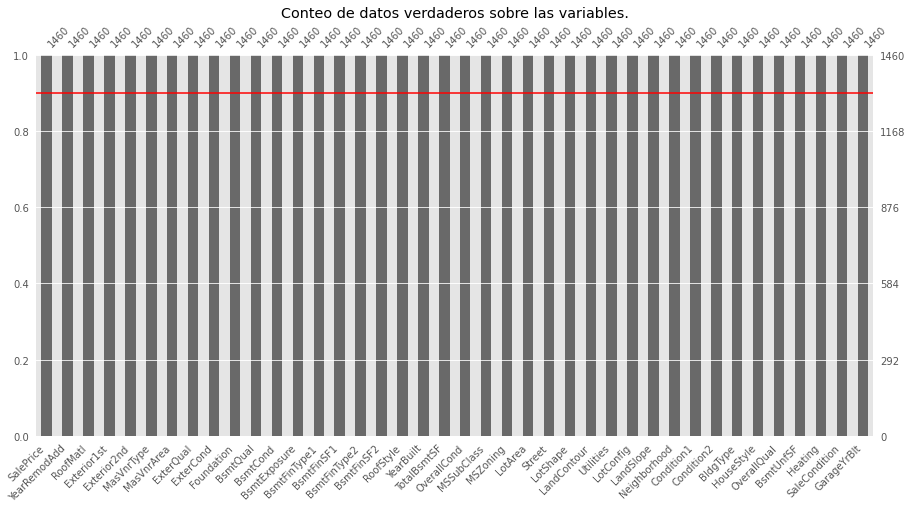

In [6]:
null_var = list(df_complete_data.isna().sum().sort_values(ascending=False).index)[0:40]
#plt.plot(df_test.isna().sum().sort_values(ascending=False))
#df_test.isna().sum().sort_values(ascending=False).head(40)
df_faltantes = df_complete_data[null_var]
#df_train['SalePrice']
fig, ax = plt.subplots()
fig.set_size_inches([15,7])
msno.bar(df_faltantes , ax = ax,fontsize=10)
xleft, xright = ax.set_xlim()
ax.hlines(y=0.90, xmin=xleft,
          xmax = xright, color = 'r')
ax.set_title('Conteo de datos verdaderos sobre las variables.')
fig.savefig("datacompletetrain.pdf")

In [7]:
df_complete_data.shape

(1460, 75)

Como podemos ver del gráfico anterior, ya no tenemos datos faltantes. c: 

Finalmente, nuestra tabla resultante tiene una muestra de $n = 1460$ registros con $m=75$ variables.

### Analicemos nuestra variable objetivo: *SalePrice*

Para mejorar nuestra estimación, tranformemos nuestra variable objetivo a una escala de $log10$. 

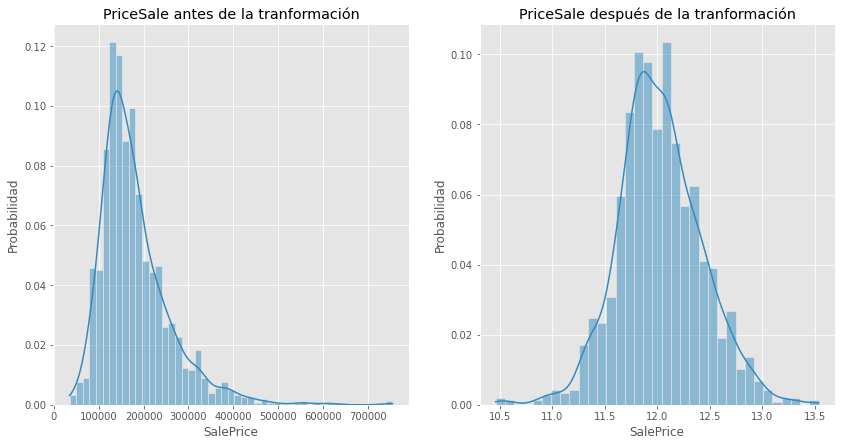

In [8]:
df_plot = df_complete_data.copy()
fig, ax = plt.subplots(1,2)
fig.set_size_inches([14,7])
ax[0].set_title("PriceSale antes de la tranformación")
sns.histplot(x = 'SalePrice', data = df_plot, kde = True, ax= ax[0], stat='probability')
ax[0].set_ylabel('Probabilidad')

ax[1].set_title("PriceSale después de la tranformación")
df_plot['SalePrice'] = np.log(df_plot['SalePrice'])
sns.histplot(x = 'SalePrice', data = df_plot, kde = True,ax= ax[1], stat='probability')
ax[1].set_ylabel('Probabilidad')

fig.savefig("pricesale.pdf")
plt.show()

In [9]:
#Prueba de normalidad 
data_test = np.log(df_complete_data['SalePrice'])
#stats.shapiro((data_test - data_test.median() ) / data_test.var() )
stats.shapiro(data_test)

(0.9912067651748657, 1.1490678986092462e-07)

### Veamos su correlación con las otras variables.

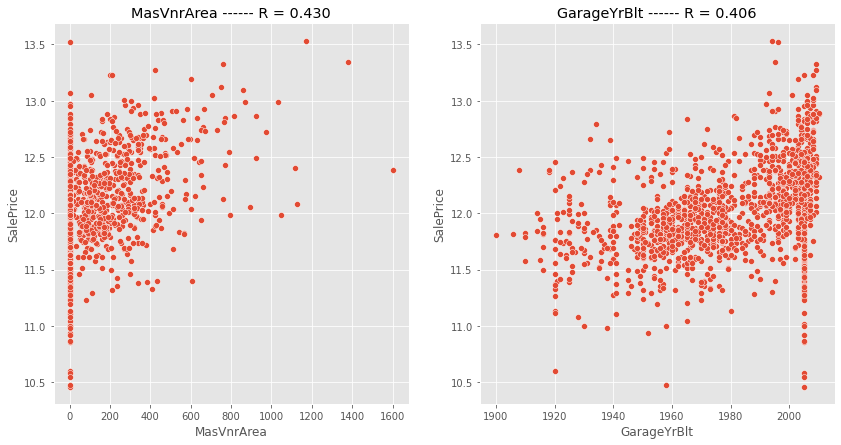

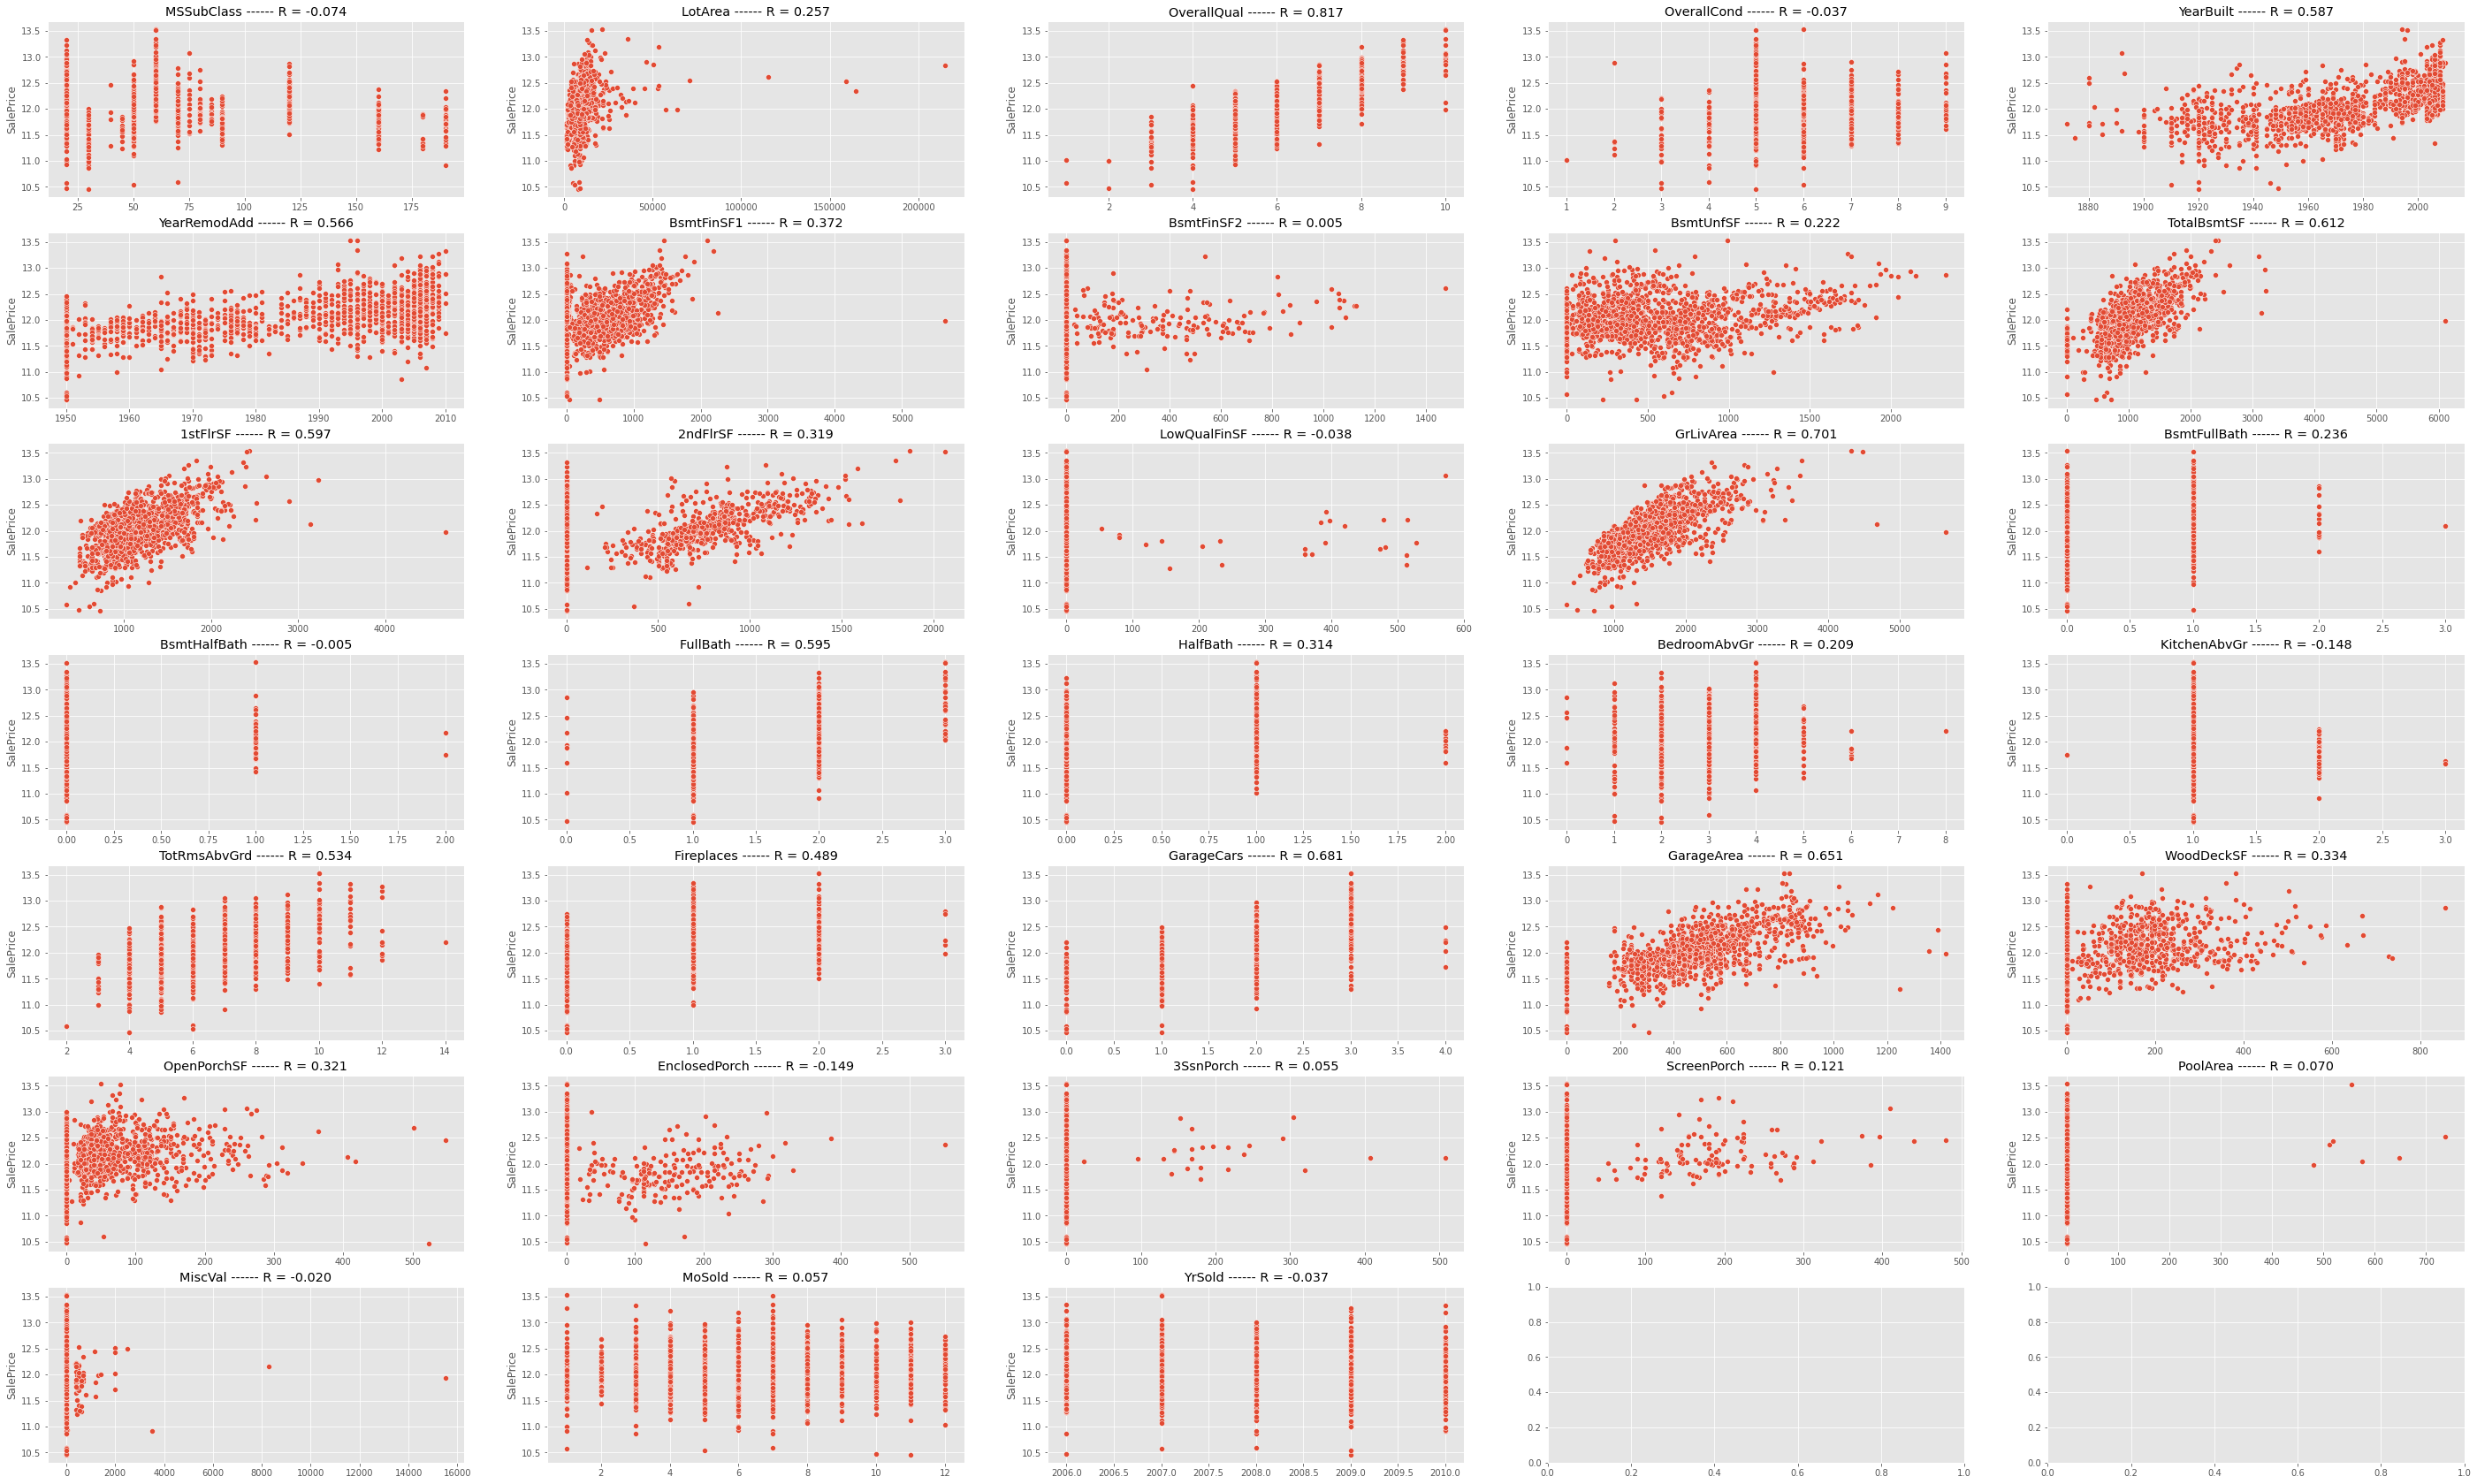

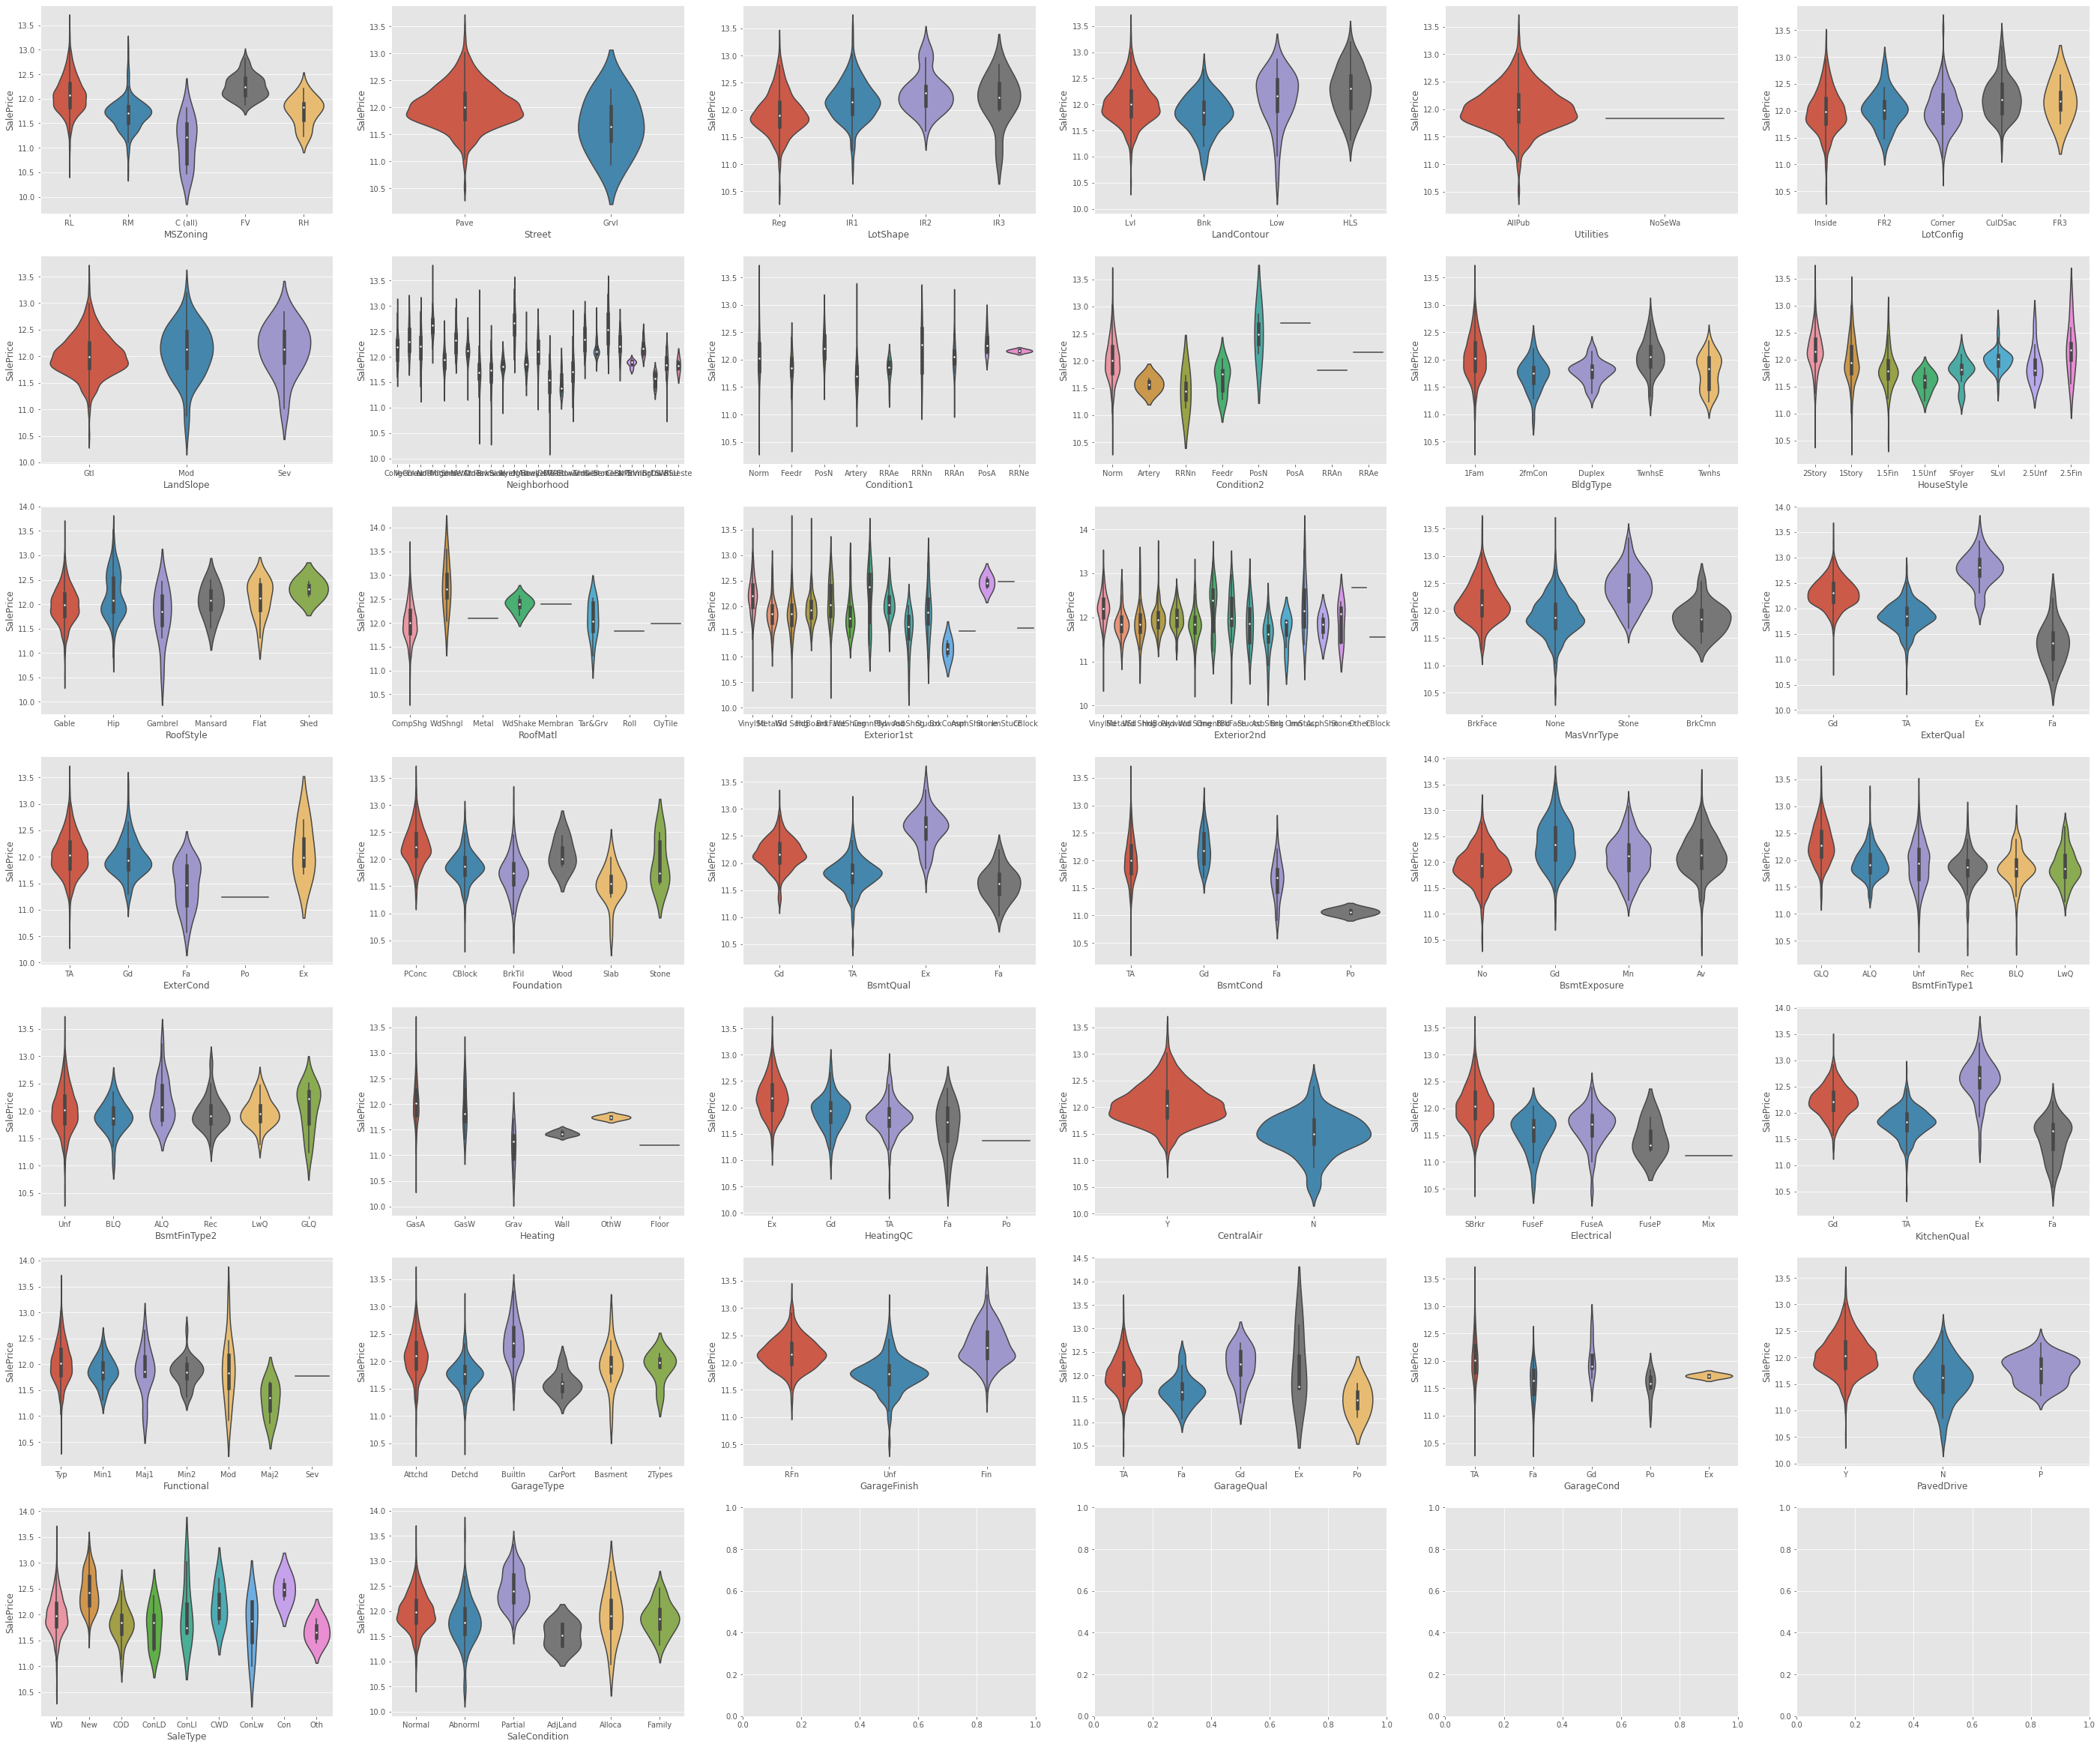

In [ ]:
df_train = df_complete_data.copy()
df_train['SalePrice'] = np.log(df_train['SalePrice'])

#df_train.dtypes.value_counts()


fig_float, ax_float = plt.subplots(1,2)
fig_float.set_size_inches([14,7])
fig_int, ax_int = plt.subplots(7,5)
fig_int.set_size_inches([49,30])
fig_object, ax_object = plt.subplots(7,6)
fig_object.set_size_inches([49,42])


list_ax_float = list(ax_float)
list_ax_int = list(ax_int[0]) +  list(ax_int[1]) + list(ax_int[2]) + list(ax_int[3]) + list(ax_int[4]) + list(ax_int[5]) + list(ax_int[6])
list_ax_object = list(ax_object[0]) +  list(ax_object[1]) + list(ax_object[2]) + list(ax_object[3]) + list(ax_object[4]) + list(ax_object[5]) + list(ax_object[6])

i_float = 0
i_int = 0
i_object = 0

dict_columns = df_train.dtypes.to_dict()

columns_to_corr = ['SalePrice']

for column in df_train.columns:
  if column != 'Id' and column != 'SalePrice':
    type_str = str(dict_columns[column])
    if type_str == 'int64':
      sns.scatterplot(x = column , y = 'SalePrice', ax= list_ax_int[i_int], data=df_train)
      df_corr_foo = df_train[['SalePrice', column]]
      #df_corr_foo[column] = np.log(df_corr_foo[column])
      corr = df_corr_foo.corr().iloc[0,1]
      list_ax_int[i_int].set_title("{} ------ R = {:.3f}".format(column,corr))
      list_ax_int[i_int].set_xlabel('')
      #sns.scatterplot(x = column , y = 'SalePrice', ax= list_ax_int[i_int], data=df_corr_foo)
      #list_ax_int[i_int].set_xscale('log')
      i_int += 1
      columns_to_corr.append(column)
    elif type_str == 'object':
      sns.violinplot(x = column, y = 'SalePrice', ax= list_ax_object[i_object], data=df_train)
      i_object += 1
    else:
      corr = df_corr_foo.corr().iloc[0,1]
      sns.scatterplot(x = column, y = 'SalePrice', ax= list_ax_float[i_float], data=df_train)
      corr = df_train[['SalePrice', column]].corr().iloc[0,1]
      list_ax_float[i_float].set_title("{} ------ R = {:.3f}".format(column,corr))
      list_ax_int[i_float].set_xlabel('')
      i_float += 1
      columns_to_corr.append(column)
  i+=1

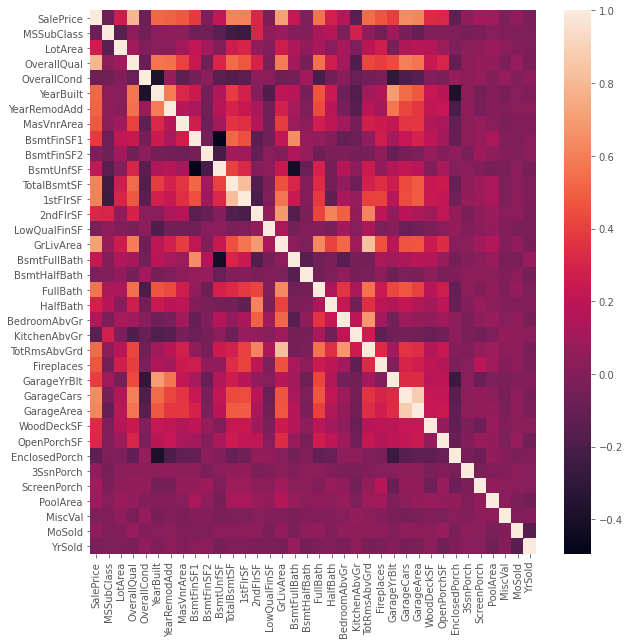

In [ ]:
df_corr = df_complete_data[columns_to_corr].copy()
fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#df_corr[df_corr.abs() < 0.2] = "hola"
sns.heatmap(df_corr.corr(), ax = ax)

fig.savefig("corr.pdf")

Algunas variables si bien son cualitativas, se tiene que deben tener cierto orden. El ejemplo más directo es ***HeatingQC***. 
Para ello, pasemos los valores a enteros poderándolos de mayor a mayor en calidad o condición.



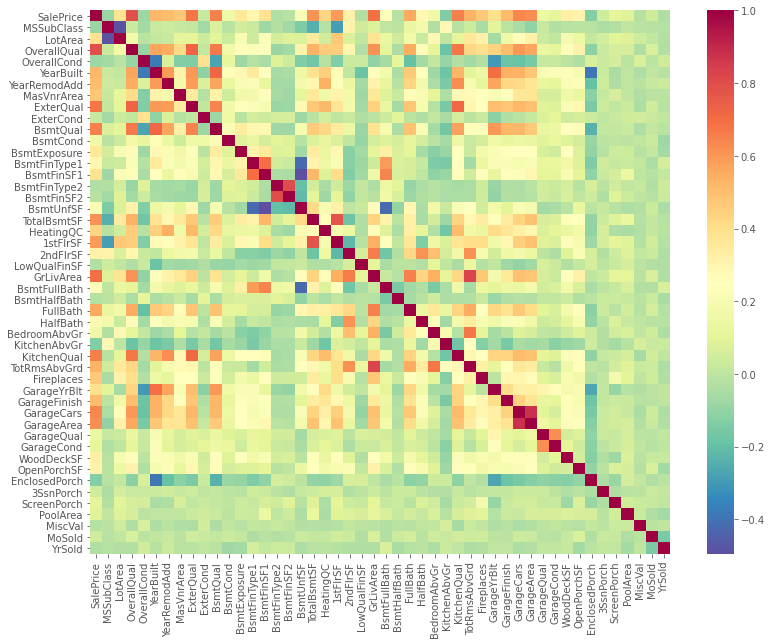

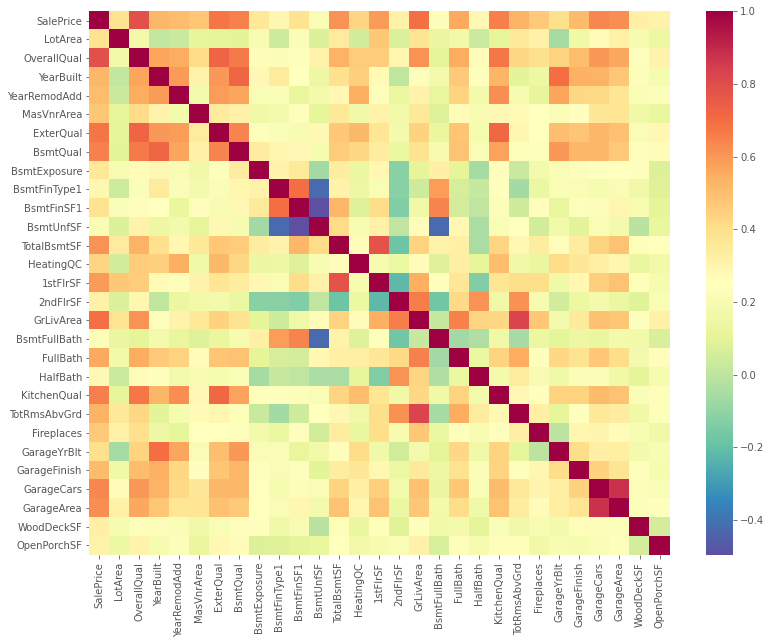

In [7]:
#@title La nueva ponderación de las variables cualitativas.
df_train = df_complete_data.copy()
columns_ponderar = ['ExterQual',
                    'ExterCond',
                    'BsmtQual',
                    'BsmtCond',
                    'BsmtExposure',
                    'BsmtFinType1',
                    'BsmtFinType2',
                    'HeatingQC',
                    'KitchenQual',
                    'GarageFinish',
                    'GarageQual',
                    'GarageCond']

dict_qual = {"Ex":5,
       "Gd":4,
       "TA":3,
       "Fa":2,
       "Po":1,
       "NA":0} 

dict_fin = {"Fin":4,
       "RFn":2,
       "Unf":	1,
       "NA":0} 

dict_exp = {"Gd":4,
       "Av":	3,	
       "Mn" :2,
       "No":	1,
       "NA": 0}

dict_qualtype = {"GLQ":	6,
       "ALQ":5,
       "BLQ":4,
       "Rec":3,
       "LwQ":2,
       "Unf":	1,
       "NA":0}


df_train['ExterQual'] = df_train['ExterQual'].replace(dict_qual)
df_train['ExterCond'] = df_train['ExterCond'].replace(dict_qual)
df_train['BsmtQual'] = df_train['BsmtQual'].replace(dict_qual)
df_train['BsmtCond'] = df_train['BsmtCond'].replace(dict_qual)
df_train['BsmtExposure'] = df_train['BsmtExposure'].replace(dict_exp)
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].replace(dict_qualtype)
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].replace(dict_qualtype)
df_train['HeatingQC'] = df_train['HeatingQC'].replace(dict_qual)
df_train['KitchenQual'] = df_train['KitchenQual'].replace(dict_qual)
df_train['GarageFinish'] = df_train['GarageFinish'].replace(dict_fin)
df_train['GarageQual'] = df_train['GarageQual'].replace(dict_qual)
df_train['GarageCond'] = df_train['GarageCond'].replace(dict_qual)

dict_columns = df_train.dtypes.to_dict()

columns_to_corr = ['SalePrice']

for column in df_train.columns:
  if column != 'Id' and column != 'SalePrice':
    type_str = str(dict_columns[column])
    if type_str == 'int64':
      columns_to_corr.append(column)
    elif type_str == 'object':
      pass
    else:
      columns_to_corr.append(column)

#print(columns_to_corr)
df_corr = df_train[columns_to_corr].copy()
#df_corr['SalePrice'] = np.log(df_corr['SalePrice'])
df_corr['LotArea'] = np.log(df_corr['LotArea'])
df_corr['1stFlrSF'] = np.log(df_corr['1stFlrSF'])
df_corr['LotArea'] = np.log(df_corr['LotArea'])
df_corr['GrLivArea'] = np.log(df_corr['GrLivArea'])
fig, ax = plt.subplots()
fig.set_size_inches([13,10])
sns.heatmap(df_corr.corr(), ax = ax,cmap="Spectral_r")
#Spectral_r
#inferno_r
#RdYlGn_r
fig.savefig("corr.pdf")

#Aquellas con correlación < 0.2
data_columns_minor =  df_corr.corr().abs().iloc[0,1:]
columns_not_corr = data_columns_minor[data_columns_minor < 0.2].index

df_corr = df_corr.drop(columns_not_corr, axis = True)
fig, ax = plt.subplots()
fig.set_size_inches([13,10])
sns.heatmap(df_corr.corr(), ax = ax,cmap="Spectral_r")


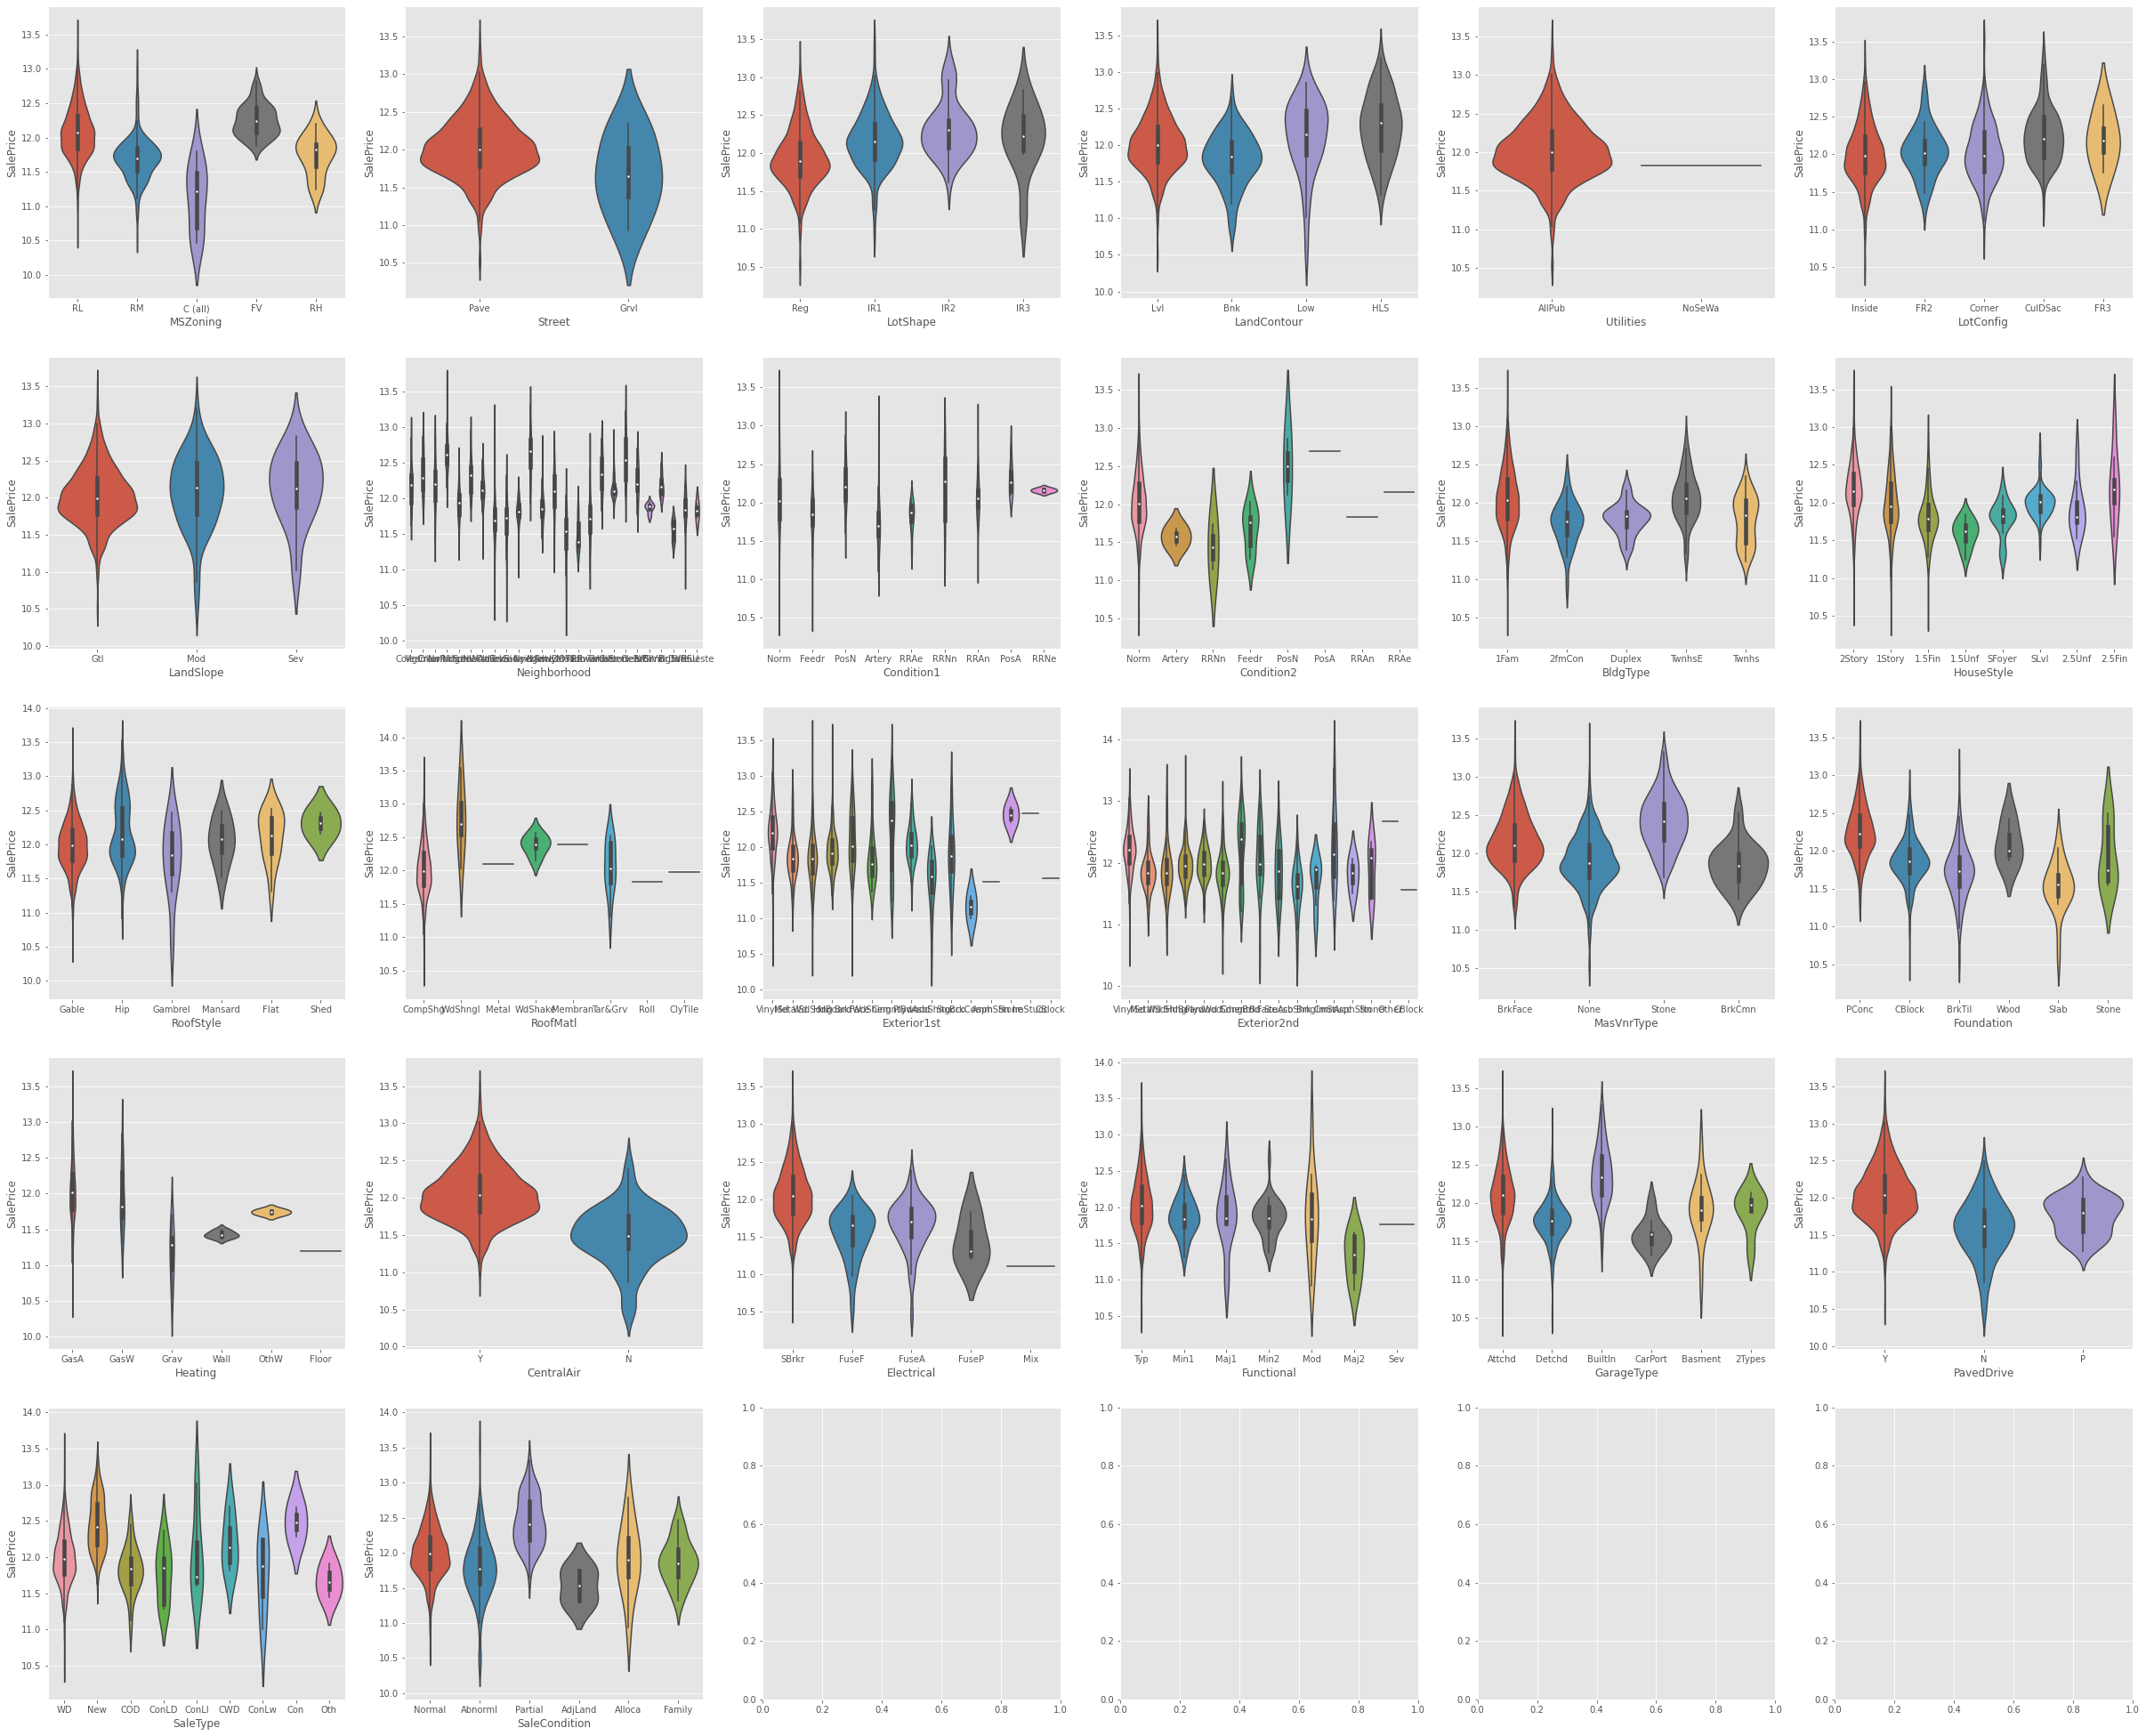

In [ ]:
dict_data_object = df_train.dtypes.to_dict()
df_foo_object = df_train.copy()
df_foo_object['SalePrice'] = np.log(df_foo_object['SalePrice'])
i = 0
fig, ax = plt.subplots(5,6)
fig.set_size_inches([42,35])
ax_list = list(ax[0]) + list(ax[1]) + list(ax[2]) + list(ax[3]) + list(ax[4])
for column in dict_data_object:
  if str(dict_data_object[column]) == 'object':
    sns.violinplot(x = column, y = 'SalePrice', ax= ax_list[i], data=df_foo_object)
    i+=1

fig.savefig("normalvairbales.pdf")

# Primer modelo: Regresión lineal.

Primero, hagamos nuestras variables dummies como queremos. Para esta aproximación, haremos un modelo con todas las variables y no hacemos algunas tranformación en la variable ***SalePrice***.

Ajustada
0.7413636328410851
R2 normal
0.9050623344470862
R2 ajustada
0.8209215014472488
Raiz del error cuadráico medio
0.01618035766886755


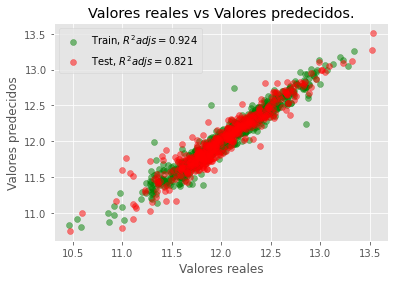

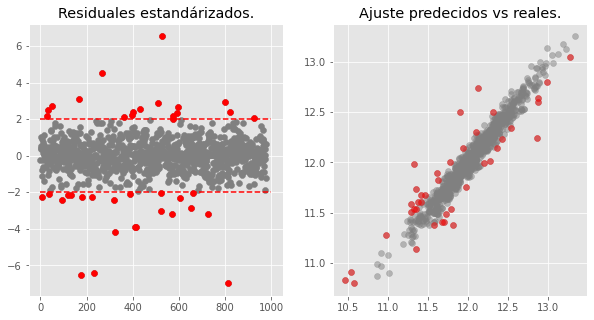

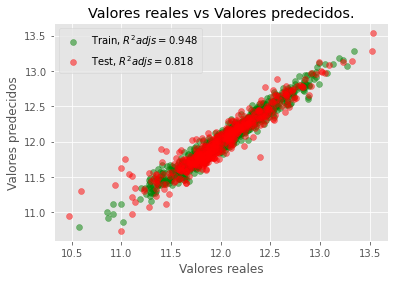

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
import statsmodels.api as sm
#r2_score()
data = df_train.copy()
X = data.drop(['SalePrice', 'Id'], axis=True)
X = pd.get_dummies(X)
#X = data.drop(['SalePrice', 'Id'], axis=True)
y = data['SalePrice']
y = np.log(data['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

#y_predict = reg.predict(X_test)
n = X_train.shape[0]
p = X_train.shape[1]
fig, ax = plt.subplots()
ax.scatter(y_train, reg.predict(X_train), color='green', alpha=0.5,
           label = 'Train, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_train, y_train))*(n-1) / (n - p -1)  ))
n = X_test.shape[0]
p = X_test.shape[1]
ax.scatter(y_test, reg.predict(X_test), color='red', alpha=0.5,
           label = 'Test, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_test, y_test))*(n-1) / (n - p -1) ))
ax.set_title('Valores reales vs Valores predecidos.')
ax.set_xlabel('Valores reales')
ax.set_ylabel('Valores predecidos')
ax.legend()

#fig.savefig("primerajuste.pdf")
foo_cross_val = cross_validate(reg, X, y, cv = 3)
print("Ajustada")
print( 1 - (1 - np.mean(foo_cross_val['test_score']))  *(n-1) / (n-p-1) )
print("R2 normal")
print( r2_score(y_test, reg.predict(X_test)))
print("R2 ajustada")
print( 1 - (1 - r2_score(y_test, reg.predict(X_test) )) * (n-1) / (n-p-1) )
print("Raiz del error cuadráico medio")
print( mean_squared_error(y_test, reg.predict(X_test) ) )

Y = y_train
X = X_train
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
#print(results.summary())
influence = results.get_influence()
cooks = influence.cooks_distance[0]
residuales = (results.resid - results.resid.mean()) / results.resid.std()
interval_5 = results.conf_int()
interval_5.columns = ['inf', 'sup'] 
pd.Series(interval_5[(interval_5['inf'] < 0)  &  (interval_5['sup'] > 0)].index).apply(lambda s: s.split('_')[0]).unique()

#plt.scatter(range(len(results.resid)),results.resid)
x_foo_array = np.array(range(len(cooks)))
fig, ax = plt.subplots(1,2)
fig.set_size_inches([10,5])
ax[0].set_title("Residuales estandárizados.")
ax[0].scatter(x_foo_array, residuales, color ='gray')
ax[0].scatter(x_foo_array[residuales.abs() > 2], residuales[residuales.abs() > 2], color ='red')
ax[0].hlines(y = 2, xmin=0,xmax=1000, linestyle ='--', color = 'red' )
ax[0].hlines(y = -2, xmin=0,xmax=1000, linestyle ='--', color = 'red' )


ax[1].scatter(y_train, reg.predict(X_train), color='gray', alpha=0.5 )
ax[1].scatter(y_train[residuales.abs() > 2], reg.predict(X_train[residuales.abs() > 2]), color='red', alpha=0.5)
ax[1].set_title("Ajuste predecidos vs reales.")

#fig.savefig("residuales.pdf")

#Sin los outliners
valor_out = 3
reg = LinearRegression().fit(X_train[residuales.abs() <= valor_out], y_train[residuales.abs() <= valor_out])
n = X_train[residuales.abs() <= valor_out].shape[0]
p = X_train[residuales.abs() <= valor_out].shape[1]
fig, ax = plt.subplots()
ax.scatter(y_train[residuales.abs() <= valor_out], reg.predict(X_train[residuales.abs() <= valor_out]), color='green', alpha=0.5,
           label = 'Train, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_train[residuales.abs() <= valor_out], y_train[residuales.abs() <= valor_out]))*(n-1) / (n - p -1)  ))
n = X_test.shape[0]
p = X_test.shape[1]
ax.scatter(y_test, reg.predict(X_test), color='red', alpha=0.5,
           label = 'Test, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_test, y_test))*(n-1) / (n - p -1) ))
ax.set_title('Valores reales vs Valores predecidos.')
ax.set_xlabel('Valores reales')
ax.set_ylabel('Valores predecidos')
ax.legend()

Hagamos uso de la paqueterías *statsmodel* para verificar los coeficientes obtenidos. 

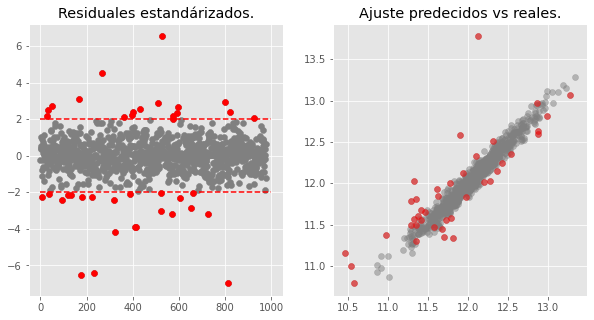

In [15]:
import statsmodels.api as sm
import statsmodels.graphics as smgraphics
Y = y_train
X = X_train
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
influence = results.get_influence()
cooks = influence.cooks_distance[0]
residuales = (results.resid - results.resid.mean()) / results.resid.std()
interval_5 = results.conf_int()
interval_5.columns = ['inf', 'sup'] 
pd.Series(interval_5[(interval_5['inf'] < 0)  &  (interval_5['sup'] > 0)].index).apply(lambda s: s.split('_')[0]).unique()

results.conf_int
#plt.scatter(range(len(results.resid)),results.resid)
x_foo_array = np.array(range(len(cooks)))
fig, ax = plt.subplots(1,2)
fig.set_size_inches([10,5])
ax[0].set_title("Residuales estandárizados.")
ax[0].scatter(x_foo_array, residuales, color ='gray')
ax[0].scatter(x_foo_array[residuales.abs() > 2], residuales[residuales.abs() > 2], color ='red')
ax[0].hlines(y = 2, xmin=0,xmax=1000, linestyle ='--', color = 'red' )
ax[0].hlines(y = -2, xmin=0,xmax=1000, linestyle ='--', color = 'red' )


ax[1].scatter(y_train, reg.predict(X_train), color='gray', alpha=0.5 )
ax[1].scatter(y_train[residuales.abs() > 2], reg.predict(X_train[residuales.abs() > 2]), color='red', alpha=0.5)
ax[1].set_title("Ajuste predecidos vs reales.")

fig.savefig("residuales.pdf")
#ax[1].plot([0,15],[0,15], color ='black')
#plt.scatter(, results.resid[results.resid.abs() > 0.2], color= 'red')

#test = results.outlier_test()
#outliers = ((x[i],y[i]) for i,t in enumerate(test.iloc[:,2]) if t < 0.5)


#Segundo modelo: Mejoramos el ajuste con outliners, tranformaciones y quitamos valores

Ajustada
0.8625676158119795
R2 normal
0.9126992351875827
R2 ajustada
0.9000198383933983
Raiz del error cuadráico medio
0.014878790111426378
(1460, 19)
-------------------------------------------------
Ajustada
0.8649799428289895
R2 normal
0.9123796270721871
R2 ajustada
0.8996538110041
Raiz del error cuadráico medio
0.014933261364651897


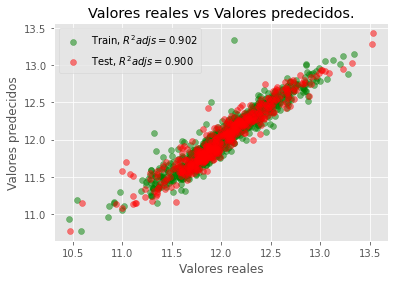

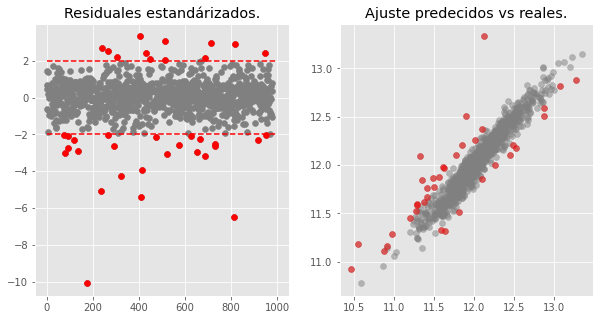

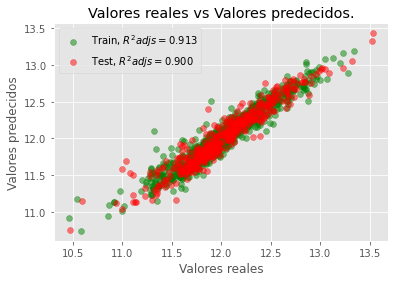

In [58]:
data = df_train.copy()

X = data.drop(['SalePrice', 'Id'], axis=True)
X = X.drop(columns_not_corr, axis= True)
X = X.drop(['SaleType',
            'SaleCondition',
            'Electrical',
            'LotConfig',
            'Utilities',
            'BldgType',
            'LandSlope',
            'MasVnrArea',
            'RoofStyle',
            'Exterior2nd',
            'PavedDrive',
            'HalfBath',
            'Heating',
            'GarageType',
            'TotRmsAbvGrd',
            'CentralAir',
            'Condition2',
            'Foundation',
            'Exterior1st',
            'MasVnrType',
            'Condition1',
            'LandContour',
            '2ndFlrSF',
            'GarageYrBlt',
            'GarageFinish',
            #'MSZoning',
            #'Street',
            'BsmtFinSF1',
            'LotShape',
            'OpenPorchSF',
            '1stFlrSF',
            'GarageCars',
            'WoodDeckSF',
            #'Neighborhood',
            'BsmtFullBath',
            'ExterQual',
            #'Functional',
            'FullBath',
            'HouseStyle'], axis = True)
#print(columns_not_corr)
X = pd.get_dummies(X)
#X = data.drop(['SalePrice', 'Id'], axis=True)
y = data['SalePrice']
y = np.log(data['SalePrice'])
#X['LotArea'] = np.log(X['LotArea'])
#X['1stFlrSF'] = np.log(X['1stFlrSF'])
X['LotArea'] = np.log(X['LotArea'])
X['GrLivArea'] = np.log(X['GrLivArea'])
#X['1stFlrSF'] = np.log(X['1stFlrSF'] )
#X['BsmtFinSF1'] = np.log(X['BsmtFinSF1'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


X_outliners = X_train.copy() 
y_outliners = y_train.copy() 


reg = LinearRegression().fit(X_outliners, y_outliners)
n = X_outliners.shape[0]
p = X_outliners.shape[1]
fig, ax = plt.subplots()
ax.scatter(y_outliners, reg.predict(X_outliners), color='green', alpha=0.5,
           label = 'Train, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_outliners, y_outliners))*(n-1) / (n - p -1)  ))
           #label = 'Train, $R^2 adjs = ${:.3f}'.format( reg.score(X_outliners, y_outliners) ) )
n = X_test.shape[0]
p = X_test.shape[1]
ax.scatter(y_test, reg.predict(X_test), color='red', alpha=0.5,
           label = 'Test, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_test, y_test))*(n-1) / (n - p -1) ))
          # label = 'Test, $R^2 = ${:.3f}'.format( reg.score(X_test, y_test)) )
ax.set_title('Valores reales vs Valores predecidos.')
ax.set_xlabel('Valores reales')
ax.set_ylabel('Valores predecidos')
ax.legend()

fig.savefig("modelo2.pdf")

#fig.savefig("primerajuste.pdf")
foo_cross_val = cross_validate(reg, X, y, cv = 3)
print("Ajustada")
print( 1 - (1 - np.mean(foo_cross_val['test_score']))  *(n-1) / (n-p-1) )
print("R2 normal")
print( r2_score(y_test, reg.predict(X_test)))
print("R2 ajustada")
print( 1 - (1 - r2_score(y_test, reg.predict(X_test) )) * (n-1) / (n-p-1) )
print("Raiz del error cuadráico medio")
print( mean_squared_error(y_test, reg.predict(X_test) ) )

Y = y_train.copy()
X = X_train.copy()
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
#print(results.summary())
influence = results.get_influence()
cooks = influence.cooks_distance[0]
residuales = (results.resid - results.resid.mean()) / results.resid.std()
interval_5 = results.conf_int()
interval_5.columns = ['inf', 'sup'] 
pd.Series(interval_5[(interval_5['inf'] < 0)  &  (interval_5['sup'] > 0)].index).apply(lambda s: s.split('_')[0]).unique()

#plt.scatter(range(len(results.resid)),results.resid)
x_foo_array = np.array(range(len(cooks)))
fig, ax = plt.subplots(1,2)
fig.set_size_inches([10,5])
ax[0].set_title("Residuales estandárizados.")
ax[0].scatter(x_foo_array, residuales, color ='gray')
ax[0].scatter(x_foo_array[residuales.abs() > 2], residuales[residuales.abs() > 2], color ='red')
ax[0].hlines(y = 2, xmin=0,xmax=1000, linestyle ='--', color = 'red' )
ax[0].hlines(y = -2, xmin=0,xmax=1000, linestyle ='--', color = 'red' )


ax[1].scatter(y_train, reg.predict(X_train), color='gray', alpha=0.5 )
ax[1].scatter(y_train[residuales.abs() > 2], reg.predict(X_train[residuales.abs() > 2]), color='red', alpha=0.5)
ax[1].set_title("Ajuste predecidos vs reales.")
fig.savefig("erroresmodelo2.pdf")

#Sin outliners

valor_out = 8
reg = LinearRegression().fit(X_train[residuales.abs() <= valor_out], y_train[residuales.abs() <= valor_out])

n = X_train[residuales.abs() <= valor_out].shape[0]
p = X_train[residuales.abs() <= valor_out].shape[1]
fig, ax = plt.subplots()
ax.scatter(y_train[residuales.abs() <= valor_out], reg.predict(X_train[residuales.abs() <= valor_out]), color='green', alpha=0.5,
           label = 'Train, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_train[residuales.abs() <= valor_out], y_train[residuales.abs() <= valor_out]))*(n-1) / (n - p -1)  ))
           #label = 'Train, $R^2  = ${:.3f}'.format(reg.score(X_train[residuales.abs() <= valor_out], y_train[residuales.abs() <= valor_out]) ))
n = X_test.shape[0]
p = X_test.shape[1]
ax.scatter(y_test, reg.predict(X_test), color='red', alpha=0.5,
           label = 'Test, $R^2 adjs = ${:.3f}'.format(1 - (1-reg.score(X_test, y_test))*(n-1) / (n - p -1) ))
           #label = 'Test, $R^2  = ${:.3f}'.format( reg.score(X_test, y_test)) )
ax.set_title('Valores reales vs Valores predecidos.')
ax.set_xlabel('Valores reales')
ax.set_ylabel('Valores predecidos')
ax.legend()

fig.savefig("sinoutliners.pdf")

X_test[reg.predict(X_test) < 11.4 ]
data_coef = pd.DataFrame({'coef':reg.coef_,
                          'col': X_test.columns})
data_coef['coef'] = data_coef['coef'].abs()
#data_coef.sort_values(by='coef', ascending=False)

#------------------------ Datos nuevos

data = df_train.copy()

X = data.drop(['SalePrice', 'Id'], axis=True)
X = X.drop(columns_not_corr, axis= True)
X = X.drop(['SaleType',
            'SaleCondition',
            'Electrical',
            'LotConfig',
            'Utilities',
            'BldgType',
            'LandSlope',
            'MasVnrArea',
            'RoofStyle',
            'Exterior2nd',
            'PavedDrive',
            'HalfBath',
            'Heating',
            'GarageType',
            'TotRmsAbvGrd',
            'CentralAir',
            'Condition2',
            'Foundation',
            'Exterior1st',
            'MasVnrType',
            'Condition1',
            'LandContour',
            '2ndFlrSF',
            'GarageYrBlt',
            'GarageFinish',
            #'MSZoning',
            #'Street',
            'BsmtFinSF1',
            'LotShape',
            'OpenPorchSF',
            '1stFlrSF',
            'GarageCars',
            'WoodDeckSF',
            #'Neighborhood',
            'BsmtFullBath',
            'ExterQual',
            #'Functional',
            'FullBath',
            'HouseStyle'], axis = True)
#print(columns_not_corr)
print(X.shape)
X = pd.get_dummies(X)
#X = data.drop(['SalePrice', 'Id'], axis=True)
y = data['SalePrice']
y = np.log(data['SalePrice'])
X['LotArea'] = np.log(X['LotArea'])
#X['1stFlrSF'] = np.log(X['1stFlrSF'])
X['LotArea'] = np.log(X['LotArea'])
X['GrLivArea'] = np.log(X['GrLivArea'])

print("-------------------------------------------------")
foo_cross_val = cross_validate(reg, X, y)
print("Ajustada")
print( 1 - (1 - np.mean(foo_cross_val['test_score']))  *(n-1) / (n-p-1) )
print("R2 normal")
print( r2_score(y_test, reg.predict(X_test)))
print("R2 ajustada")
print( 1 - (1 - r2_score(y_test, reg.predict(X_test) )) * (n-1) / (n-p-1) )
print("Raiz del error cuadráico medio")
print( mean_squared_error(y_test, reg.predict(X_test) ) )

Y = y_train.copy()
X = X_train.copy()
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
#print(results.summary())
influence = results.get_influence()
cooks = influence.cooks_distance[0]
residuales = (results.resid - results.resid.mean()) / results.resid.std()
interval_5 = results.conf_int()
interval_5.columns = ['inf', 'sup'] 
#pd.Series(interval_5[(interval_5['inf'] < 0)  &  (interval_5['sup'] > 0)].index).apply(lambda s: s.split('_')[0]).unique()

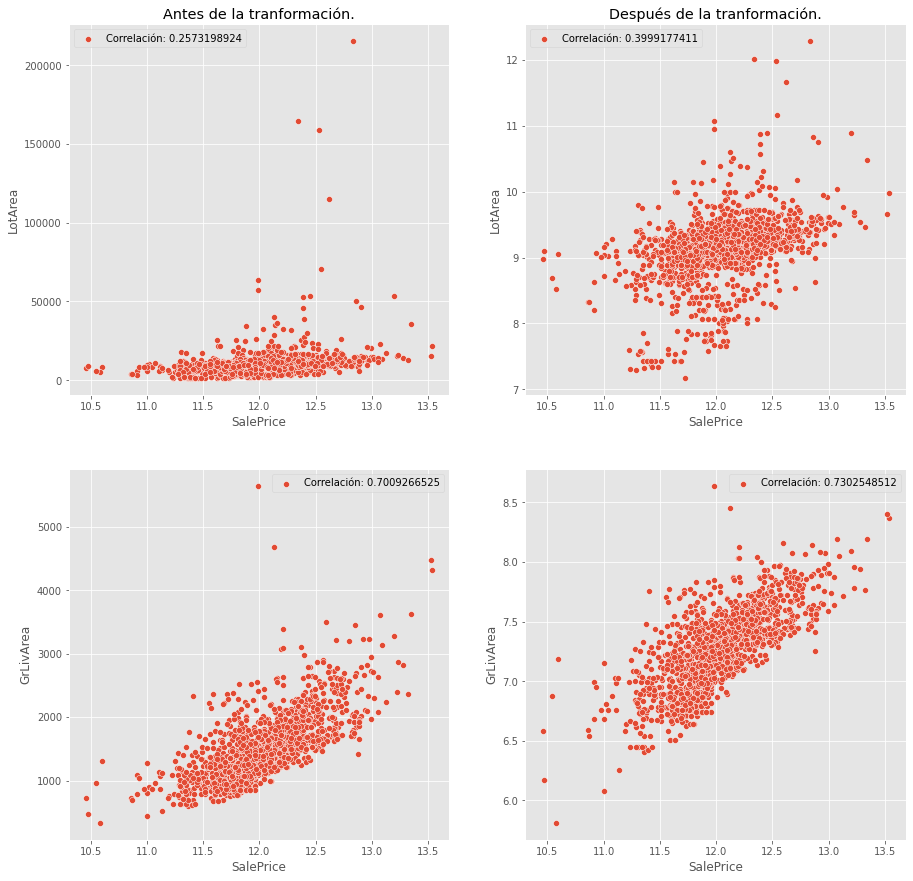

In [74]:
data = df_train.copy()
data['SalePrice'] = np.log(data['SalePrice'])

fig, ax = plt.subplots(2,2)
fig.set_size_inches([15,15])
list_ax = list(ax[0]) + list(ax[1])
i = 0
for element in ['LotArea', 'GrLivArea']:
  #Antes
  a = sns.scatterplot(x='SalePrice', y =element, ax=list_ax[i], data=data)
  r = data[['SalePrice', element]].corr().iloc[0,1]
  if i < 1:
    list_ax[i].set_title("Antes de la tranformación.")
  list_ax[i].legend(['Correlación: {:.10f}'.format(r)])

  data[element] = np.log(data[element])
  r = data[['SalePrice', element]].corr().iloc[0,1]
  i+=1
  if i == 1:
    list_ax[i].set_title("Después de la tranformación.")
  sns.scatterplot(x='SalePrice', y =element, ax=list_ax[i], data=data)
  list_ax[i].legend(['Correlación: {:.10f}'.format(r)])
  i+=1

fig.savefig("Sobrelastranformaciones.pdf")
#X['GrLivArea'] = np.log(X['GrLivArea'])

# Veamos la comparación la funcionalidad del modelo con la base test.

Text(0.5, 1.0, 'Conteo de datos verdaderos sobre las variables.')

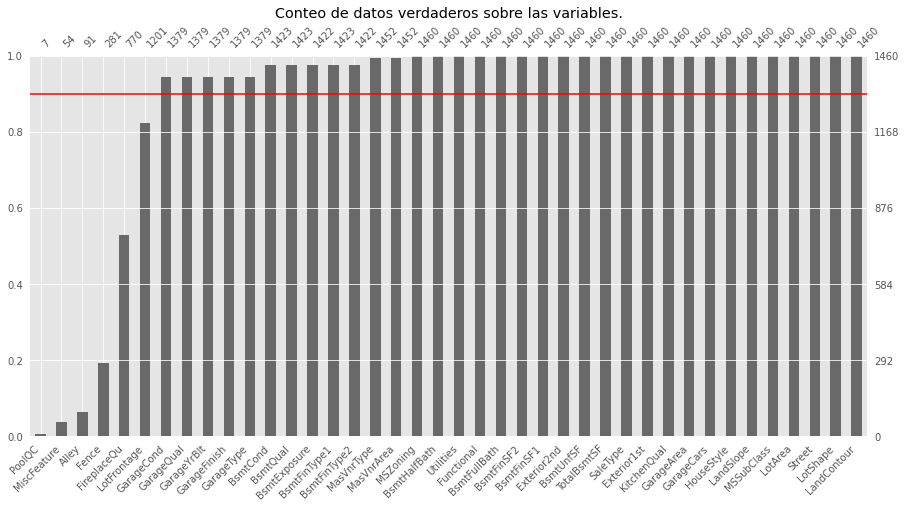

In [59]:
df_data_test = df_test.copy()
array_id = df_data_test['Id']

null_var = list(df_data_test.isna().sum().sort_values(ascending=False).index)[0:40]
#plt.plot(df_test.isna().sum().sort_values(ascending=False))
#df_test.isna().sum().sort_values(ascending=False).head(40)
df_faltantes = df_data[null_var]
#df_train['SalePrice']
fig, ax = plt.subplots()
fig.set_size_inches([15,7])
msno.bar(df_faltantes , ax = ax,fontsize=10)
xleft, xright = ax.set_xlim()
ax.hlines(y=0.90, xmin=xleft,
          xmax = xright, color = 'r')
ax.set_title('Conteo de datos verdaderos sobre las variables.')

In [60]:
column_eliminate = ["PoolQC",
                    "MiscFeature",
                    "Alley",
                    "Fence",
                    "FireplaceQu",
                    "LotFrontage"]

df_columns_int = df_data_test.drop(column_eliminate, axis = 1)
#df_columns_int['SalePrice'] = np.log(df_columns_int['SalePrice'])

#Columnas con algunos datos faltantes
list_null_axes = df_columns_int.isna().sum()[df_columns_int.isna().sum() > 0 ].index
dict_type = df_columns_int.dtypes.to_dict()

columns_objets = [column for column in list_null_axes if str(dict_type[column]) != 'float64' or column == 'GarageYrBlt']
columns_float = [column for column in list_null_axes if str(dict_type[column]) == 'float64' and column != 'GarageYrBlt']

df_complete_data = df_columns_int.copy()

#Para las continuas
imputer = KNNImputer(n_neighbors=5)
df_complete_data[columns_float] = imputer.fit_transform(df_complete_data[columns_float])

#Para las otras
imp = SimpleImputer(strategy="most_frequent")
df_complete_data[columns_objets] = imp.fit_transform(df_complete_data[columns_objets])

df_test_final = df_complete_data.copy()
columns_ponderar = ['ExterQual',
                    'ExterCond',
                    'BsmtQual',
                    'BsmtCond',
                    'BsmtExposure',
                    'BsmtFinType1',
                    'BsmtFinType2',
                    'HeatingQC',
                    'KitchenQual',
                    'GarageFinish',
                    'GarageQual',
                    'GarageCond']

dict_qual = {"Ex":5,
       "Gd":4,
       "TA":3,
       "Fa":2,
       "Po":1,
       "NA":0} 

dict_fin = {"Fin":4,
       "RFn":2,
       "Unf":	1,
       "NA":0} 

dict_exp = {"Gd":4,
       "Av":	3,	
       "Mn" :2,
       "No":	1,
       "NA": 0}

dict_qualtype = {"GLQ":	6,
       "ALQ":5,
       "BLQ":4,
       "Rec":3,
       "LwQ":2,
       "Unf":	1,
       "NA":0}


df_test_final['ExterQual'] = df_test_final['ExterQual'].replace(dict_qual)
df_test_final['ExterCond'] = df_test_final['ExterCond'].replace(dict_qual)
df_test_final['BsmtQual'] = df_test_final['BsmtQual'].replace(dict_qual)
df_test_final['BsmtCond'] = df_test_final['BsmtCond'].replace(dict_qual)
df_test_final['BsmtExposure'] = df_test_final['BsmtExposure'].replace(dict_exp)
df_test_final['BsmtFinType1'] = df_test_final['BsmtFinType1'].replace(dict_qualtype)
df_test_final['BsmtFinType2'] = df_test_final['BsmtFinType2'].replace(dict_qualtype)
df_test_final['HeatingQC'] = df_test_final['HeatingQC'].replace(dict_qual)
df_test_final['KitchenQual'] = df_test_final['KitchenQual'].replace(dict_qual)
df_test_final['GarageFinish'] = df_test_final['GarageFinish'].replace(dict_fin)
df_test_final['GarageQual'] = df_test_final['GarageQual'].replace(dict_qual)
df_test_final['GarageCond'] = df_test_final['GarageCond'].replace(dict_qual)

In [61]:
X_test_final = df_test_final.drop(['Id'], axis=True)
X_test_final = X_test_final.drop(columns_not_corr, axis = True)
X_test_final = X_test_final.drop(['SaleType',
            'SaleCondition',
            'Electrical',
            'LotConfig',
            'Utilities',
            'BldgType',
            'LandSlope',
            'MasVnrArea',
            'RoofStyle',
            'Exterior2nd',
            'PavedDrive',
            'HalfBath',
            'Heating',
            'GarageType',
            'TotRmsAbvGrd',
            'CentralAir',
            'Condition2',
            'Foundation',
            'Exterior1st',
            'MasVnrType',
            'Condition1',
            'LandContour',
            '2ndFlrSF',
            'GarageYrBlt',
            'GarageFinish',
            #'MSZoning',
            #'Street',
            'BsmtFinSF1',
            'LotShape',
            'OpenPorchSF',
            '1stFlrSF',
            'GarageCars',
            'WoodDeckSF',
            #'Neighborhood',
            'BsmtFullBath',
            'ExterQual',
            #'Functional',
            'FullBath',
            'HouseStyle'], axis = True)
#Verificamos que tengan el mismo orden las columnas 
data = X_train.copy()
#X = data.drop(['SalePrice', 'Id'], axis=True)

X_test_final['LotArea'] = np.log(X_test_final['LotArea'])
#X_test_final['1stFlrSF'] = np.log(X_test_final['1stFlrSF'])
X_test_final['LotArea'] = np.log(X_test_final['LotArea'])
X_test_final['GrLivArea'] = np.log(X_test_final['GrLivArea'])

X_columns = pd.get_dummies(X_train).columns

X_test_foo_ = pd.get_dummies(X_test_final)
X_test_foo_ = X_test_foo_[list(set(X_columns) & set(X_test_foo_))]
faltantes = set(X_columns) - set(X_test_foo_)

for column_faltante in faltantes:
  X_test_foo_[column_faltante] = 0
X_test_foo_ = X_test_foo_[X_columns]

print(X_test_foo_)
SalePrice = np.exp(reg.predict(X_test_foo_))

final_df = pd.DataFrame({'Id': array_id,
                         'SalePrice': SalePrice})
final_df.to_csv('finalsub.csv', index = False)

      LotArea  OverallQual  ...  Functional_Sev  Functional_Typ
0        2.24            5  ...               0               1
1        2.26            6  ...               0               1
2        2.25            5  ...               0               1
3        2.22            6  ...               0               1
4        2.14            8  ...               0               1
...       ...          ...  ...             ...             ...
1454     2.02            4  ...               0               1
1455     2.02            4  ...               0               1
1456     2.29            5  ...               0               1
1457     2.23            5  ...               0               1
1458     2.22            7  ...               0               1

[1459 rows x 61 columns]


In [62]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f finalsub.csv -m "Sin algunas variables"

100% 33.7k/33.7k [00:01<00:00, 22.7kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

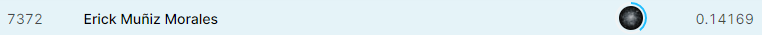